## Problem Statement:
    1. TOP 5 empresas que + compravam
    2. 5 prod + vendidos
    3. 5 prod + faturamento
### EXTRA: 
    4. Distribuição de venda total por mês

## Tabela 1: Tabela geral para consumo (deveria talvez ser a camada SILVER?)
  | ID_Pedido | ID_Estabelecimento | Nome Estabelecimento | Produto | Quantidade | Preço | Faturamento|
  |---------|------|--|---|---------|------|--|

## Tabela 2:
  | ID_Estabelecimento | Nome Estabelecimento | Quantidade | Faturamento|Custo Unitário Médio|
  |------|--|---|---------|------|
  |-|-|SOMA|SOMA|FAT/QTT|

## Tabela 3:
  | Produto | Quantidade | Preço | Faturamento| # Pedidos | Qtt/pedido | $/pedido |
  |---------|------|--|---|---------|------|--|
  |-|SOMA|-|SOMA|COUNT|formula|formula|


In [0]:
import matplotlib.pyplot as plt

In [0]:
%sql
SELECT * FROM silver.pedidos
LIMIT 2;

id_pedido,id_estabelecimento,Produto,quantidade_vendida,Preco_Unitario,data_venda,nome_estabalecimento,Email,Telefone
1,50,Suco Natural,440,11.11,2023-07-22,Bar do João,joao@bardojoao.com,(71) 98909-8853
2,12,Refrigerante 123,278,15.45,2024-07-06,Pastelaria do Mário,contato@pastelariadomario.com,(21) 99320-8273


In [0]:
%sql
-- ITEM 1
SELECT 
  id_estabelecimento, 
  nome_estabalecimento,
  SUM(quantidade_vendida * Preco_Unitario) AS faturamento,
  SUM(quantidade_vendida) AS quantidade_total,
  CAST(faturamento/quantidade_total AS DECIMAL(20,2)) AS preco_medio
FROM silver.pedidos
GROUP BY 
  id_estabelecimento,
  nome_estabalecimento
ORDER BY faturamento DESC
LIMIT 5;

id_estabelecimento,nome_estabalecimento,faturamento,quantidade_total,preco_medio
15,Padoca do Zé,40116.67,3077,13.04
27,Oficina Mecânica,32641.69,2188,14.92
4,Padaria do Paulo,29919.66,2361,12.67
31,Bar e Grill,27440.37,1902,14.43
39,Bar da Esquina,27249.56,2065,13.20


In [0]:
%sql
-- ITEM 2
SELECT 
  Produto, 
  SUM(quantidade_vendida * Preco_Unitario) AS faturamento,
  SUM(quantidade_vendida) AS quantidade_total,
  CAST(faturamento/quantidade_total AS DECIMAL(20,2)) AS preco_medio
FROM silver.pedidos
GROUP BY 
  Produto
ORDER BY quantidade_total DESC
LIMIT 5;

Produto,faturamento,quantidade_total,preco_medio
Cerveja XYZ,165041.51,15036,10.98
Vinho ABC,168253.57,14191,11.86
Suco Natural,126052.65,12931,9.75
Água Mineral,135812.69,12874,10.55
Refrigerante 123,129574.58,11741,11.04


In [0]:
%sql
-- ITEM 3
SELECT 
  Produto, 
  SUM(quantidade_vendida * Preco_Unitario) AS faturamento,
  SUM(quantidade_vendida) AS quantidade_total,
  CAST(faturamento/quantidade_total AS DECIMAL(20,2)) AS preco_medio
FROM silver.pedidos
GROUP BY 
  Produto
ORDER BY faturamento DESC
LIMIT 5;

Produto,faturamento,quantidade_total,preco_medio
Vinho ABC,168253.57,14191,11.86
Cerveja XYZ,165041.51,15036,10.98
Água Mineral,135812.69,12874,10.55
Refrigerante 123,129574.58,11741,11.04
Suco Natural,126052.65,12931,9.75


In [0]:
%sql
-- 2. 5 prod + vendidos
-- jeito 2 de fazer (mais economico em memória, provavelmente!)
SELECT 
  Produto,
  SUM(quantidade_vendida) AS total_quantidade_vendida
FROM
  silver.pedidos
GROUP BY
  Produto
ORDER BY SUM(quantidade_vendida) DESC
LIMIT 5;

Produto,total_quantidade_vendida
Cerveja XYZ,15036
Vinho ABC,14191
Suco Natural,12931
Água Mineral,12874
Refrigerante 123,11741


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
-- 3. 5 prod + faturamento
-- jeito 2 de fazer (mais economico em memória, provavelmente!)
SELECT 
  Produto,
  SUM(quantidade_vendida*Preco_Unitario) AS faturamento
FROM
  silver.pedidos
GROUP BY
  Produto
ORDER BY SUM(quantidade_vendida*Preco_Unitario) DESC
LIMIT 5;

Produto,faturamento
Vinho ABC,168253.57
Cerveja XYZ,165041.51
Água Mineral,135812.69
Refrigerante 123,129574.58
Suco Natural,126052.65


In [0]:
%sql

SELECT
  MIN(data_venda),
  MAX(data_venda)
FROM silver.pedidos;

min(data_venda),max(data_venda)
2023-07-11,2024-07-10


In [0]:
%sql
-- Ver o faturamento MENSAL
---- Selecionar lista de top 5 estabelec
WITH 
  top5_estabelecimentos AS (
  SELECT 
    id_estabelecimento
  FROM silver.pedidos
  GROUP BY id_estabelecimento
  ORDER BY SUM(quantidade_vendida * Preco_Unitario) DESC
  LIMIT 5
)
SELECT
  date_format(data_venda, 'yyyy-MM') AS year_month,
  SUM(quantidade_vendida * Preco_Unitario) AS faturamento,
  SUM(CASE 
        WHEN id_estabelecimento IN (
          SELECT id_estabelecimento FROM top5_estabelecimentos
        ) THEN (quantidade_vendida * Preco_Unitario)
        ELSE 0
      END) AS faturam_top5_empresas
FROM silver.pedidos
GROUP BY year_month
ORDER BY year_month ASC;

year_month,faturamento,faturam_top5_empresas
2023-07,33987.27,5384.01
2023-08,63758.35,24514.56
2023-09,81294.98,7787.16
2023-10,45259.91,16371.05
2023-11,66792.56,16301.82
2023-12,57310.15,6913.14
2024-01,55308.10,22994.81
2024-02,58914.52,7466.65
2024-03,57272.58,6760.92
2024-04,59854.70,16490.54


In [0]:
## Plotar um gráfico!

df = spark.sql("""
WITH top5_estabelecimentos AS (
  SELECT 
    id_estabelecimento
  FROM silver.pedidos
  GROUP BY id_estabelecimento
  ORDER BY SUM(quantidade_vendida * Preco_Unitario) DESC
  LIMIT 5
)
SELECT
  date_format(data_venda, 'yyyy-MM') AS year_month,
  SUM(quantidade_vendida * Preco_Unitario) AS faturamento,
  SUM(CASE 
        WHEN id_estabelecimento IN (
          SELECT id_estabelecimento FROM top5_estabelecimentos
        ) THEN (quantidade_vendida * Preco_Unitario)
        ELSE 0
      END) AS faturam_top5_empresas
FROM silver.pedidos
GROUP BY year_month
ORDER BY year_month ASC
""").toPandas()

/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [faturamento, faturam_top5_empresas] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


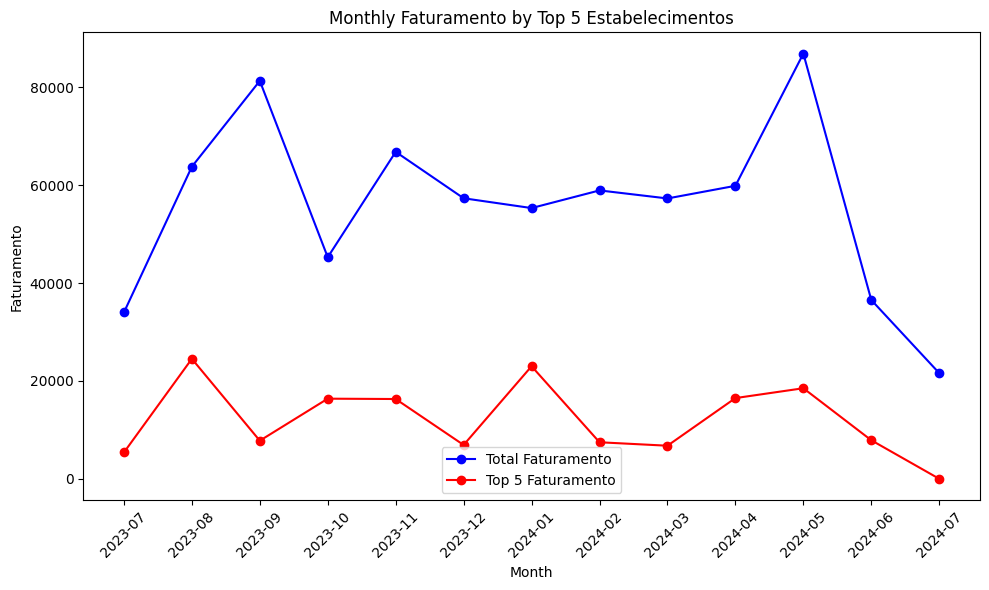

In [0]:
#Definir figura
plt.figure(figsize=(10,6))

# Plotar faturamento
plt.plot(df['year_month'], df['faturamento'], label='Total Faturamento', marker='o', color='blue')

# Plotar faturam_top5_empresas
plt.plot(df['year_month'], df['faturam_top5_empresas'], label='Top 5 Faturamento', marker='o', color='red')

# adicionar Labels
plt.title('Monthly Faturamento by Top 5 Estabelecimentos')
plt.xlabel('Month')
plt.ylabel('Faturamento')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()

plt.tight_layout()
plt.show()